## What is the impact of varying the number of hidden neurons, when ou rdata has 10 populations? One would expect a spike of reconstructions quality at 10 hiddens.

Imports

In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.stats import pearsonr
from tqdm import tqdm

from data.reshape_data import reshape, reshape_from_batches
from data.poisson_data_v import PoissonTimeShiftedData
from utils.funcs import pairwise_moments, get_reconstruction_mean_pairwise_correlations
from boltzmann_machines.cp_rtrbm import RTRBM

Simulation parameters

In [6]:
n_v = 100
n_h = 10
delay = 1  # temporal dynamics
frequency_range = [5, 10]
phase_range = [0, torch.pi]
amplitude_range = [0.4, 0.5]

hiddens_range = [2, 5, 8, 10, 12, 15, 20]
N = 3  # number of RTRBMs per run

0it [00:00, ?it/s]

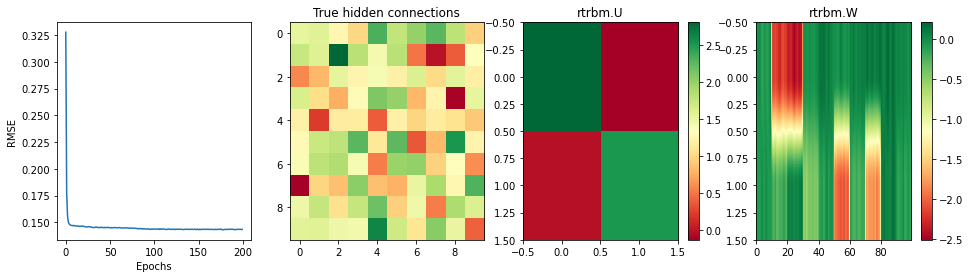

7it [3:12:05, 1646.48s/it]


In [7]:
rtrbm_list = []
rec_errors = torch.zeros(len(hiddens_range), N)
rec_corr = torch.zeros(len(hiddens_range), N)
mean_corr = torch.zeros(len(hiddens_range), N)
pw_corr = torch.zeros(len(hiddens_range), N)

for i, n_hidden in tqdm(enumerate(hiddens_range)):

    for n in range(N):

        # initialize random temporal connections
        temporal_connections = torch.randn(n_h, n_h) / n_h

        # get data
        gaus = PoissonTimeShiftedData(
            neurons_per_population=n_v//n_h, n_populations=n_h, n_batches=1, time_steps_per_batch=35000,
            fr_mode='gaussian', delay=delay, temporal_connections=temporal_connections, norm=1,
            frequency_range=frequency_range, amplitude_range=amplitude_range, phase_range=phase_range
        )

        # split data in train and test set
        data = reshape(gaus.data[..., 0], T=100, n_batches=350)
        train, test = data[..., :280], data[..., 280:]

        # initialize and train RTRBM
        rtrbm = RTRBM(train, N_H=n_hidden, device="cpu", debug_mode=False)
        rtrbm.learn(batch_size=10, n_epochs=200, max_lr=1e-3, min_lr=8e-4, lr_schedule='geometric_decay', CDk=10, mom=0.6, wc=0.0002, sp=0, x=1, disable_tqdm=True)

        # perform a plot to test if simulation went well
        if i == 0 and n == 0:
            fig, ax = plt.subplots(1, 4, figsize=(16, 4))
            ax[0].plot(rtrbm.errors)
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel('RMSE')
            ax[1].imshow(gaus.temporal_connections, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
            ax[1].set_title('True hidden connections')
            cm = ax[2].imshow(rtrbm.U, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
            fig.colorbar(cm, ax=ax[2])
            ax[2].set_title('rtrbm.U')
            cm = ax[3].imshow(rtrbm.W, aspect='auto', cmap=plt.get_cmap('RdYlGn'))
            fig.colorbar(cm, ax=ax[3])
            ax[3].set_title('rtrbm.W')

            plt.show()

        # infer over all test batches
        T, n_batches = test.shape[1], test.shape[2]
        vs = torch.zeros(n_v, T, n_batches)
        for batch in range(n_batches):
            vs[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

        # save rec error and correlations
        rec_errors[i, n] = torch.mean((vs[:, :T//2, :] - test[:, :T//2, :])**2)
        rec_corr[i, n], mean_corr[i, n], pw_corr[i, n] = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

        # save rtrbm temporarily in list
        rtrbm_list += [rtrbm]

In [58]:
for i, rtrbm in tqdm(enumerate(rtrbm_list)):

    T, n_batches = test.shape[1], test.shape[2]
    vs = torch.zeros(n_v, T, n_batches)
    for batch in range(n_batches):
        vs[:, :, batch], _ = rtrbm.infer(test[:, :T//2, batch], mode=1, pre_gibbs_k=100, gibbs_k=100, disable_tqdm=True)

    # save rec error and correlations
    rec_errors[i // 3, i % 3] = torch.mean((vs[:, T//2:, :] - test[:, T//2:, :])**2)
    rec_corr[i // 3, i % 3], mean_corr[i // 3, i % 3], pw_corr[i // 3, i % 3] = get_reconstruction_mean_pairwise_correlations(test[:, T//2:, :], vs[:, T//2:, :])

21it [09:11, 26.27s/it]


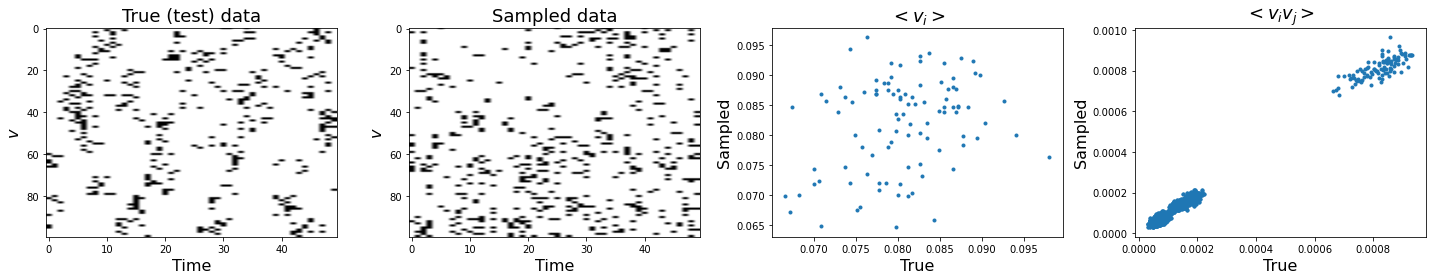

In [59]:
vs_ = reshape_from_batches(vs)
test_ = reshape_from_batches(test)
true_pairwise = pairwise_moments(test_, test_).flatten()
sampled_pairwise = pairwise_moments(vs_, vs_).flatten()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

axes[0].imshow(test[:, T//2:, 0], cmap=plt.get_cmap('binary'), aspect='auto')
axes[1].imshow(vs[:, T//2:, 0], cmap=plt.get_cmap('binary'), aspect='auto')
axes[2].plot(torch.mean(vs[:, T//2:, :], (1, 2)), torch.mean(test[:, T//2:, :], (1, 2)), '.')
axes[3].plot(true_pairwise, sampled_pairwise, '.')

axes[0].set_title('True (test) data', fontsize=18)
axes[0].set_xlabel('Time', fontsize=16)
axes[0].set_ylabel('$v$', fontsize=16)
axes[1].set_title('Sampled data', fontsize=18)
axes[1].set_xlabel('Time', fontsize=16)
axes[1].set_ylabel('$v$', fontsize=16)
axes[2].set_title('$<v_i>$', fontsize=18)
axes[2].set_xlabel('True', fontsize=16)
axes[2].set_ylabel('Sampled', fontsize=16)
axes[3].set_title('$<v_iv_j>$', fontsize=18)
axes[3].set_xlabel('True', fontsize=16)
axes[3].set_ylabel('Sampled', fontsize=16)

plt.tight_layout()
plt.show()

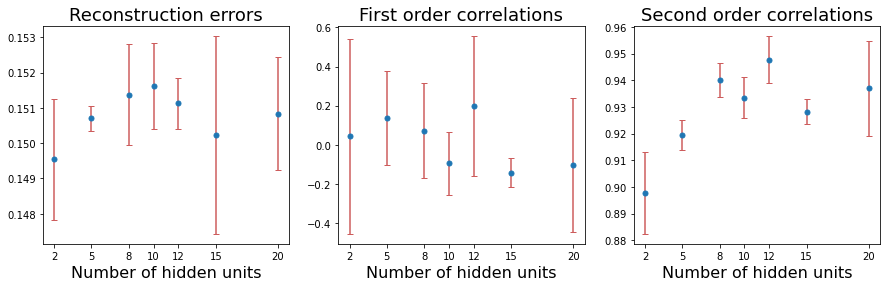

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].errorbar(hiddens_range, torch.mean(rec_errors, 1), torch.std(rec_errors, 1), linestyle='None', marker='.', markersize=10, capsize=3, ecolor='indianred')
axes[1].errorbar(hiddens_range, torch.mean(mean_corr, 1), torch.std(mean_corr, 1), linestyle='None', marker='.', markersize=10, capsize=3, ecolor='indianred')
axes[2].errorbar(hiddens_range, torch.mean(pw_corr, 1), torch.std(pw_corr, 1), linestyle='None', marker='.', markersize=10, capsize=3, ecolor='indianred')

axes[0].set_title('Reconstruction errors', fontsize=18)
axes[0].set_xlabel('Number of hidden units', fontsize=16)
axes[1].set_title('First order correlations', fontsize=18)
axes[1].set_xlabel('Number of hidden units', fontsize=16)
axes[2].set_title('Second order correlations', fontsize=18)
axes[2].set_xlabel('Number of hidden units', fontsize=16)

for ax in axes:
    ax.set_xticks(hiddens_range)

plt.show()

Reconstruction errors remain the same. First order correlations do not perform well because we have a very low range of firing rates. Second order correlation's performance plateau at 8-10 hidden neurons, as expected.